In [1]:
import torch
import dataset.create_dataset as D
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau


import warnings

# Ignore DeprecationWarnings
warnings.filterwarnings("ignore")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

LEARNING_RATE = 1e-2
img_H, img_W = 128, 224

num_epochs = 5
batch_size = D.BATCH_SIZE


In [3]:

def loss_fc(outputs, targets):
    out1, out2, out3 = outputs
    t1, t2, t3 = targets

    loss1 = nn.CrossEntropyLoss()(out1, t1)
    loss2 = nn.CrossEntropyLoss()(out2, t2)
    loss3 = nn.CrossEntropyLoss()(out3, t3)

    return (loss1 + loss2 + loss3)/3

In [4]:
from models.resnet34 import resnet34

In [5]:
model = resnet34().to(device)

train_loader,_, val_loader = D.dividing_datasets(img_H, img_W)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, threshold=1e-4, cooldown=3)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [6]:
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for _, data in enumerate(train_loader):
          image = data["image"]
          grapheme_root = data["grapheme_root"]
          vowel_diacritic = data["vowel_diacritic"]
          consonant_diacritic = data["consonant_diacritic"]

          image = image.to(device, dtype=torch.float)
          grapheme_root = grapheme_root.to(device, dtype=torch.long)
          vowel_diacritic = vowel_diacritic.to(device, dtype=torch.long)
          consonant_diacritic = consonant_diacritic.to(device, dtype=torch.long)

          targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

          optimizer.zero_grad()

          outputs = model(image)

          total_loss = loss_fc(outputs, targets)

          # Backward and optimize
          total_loss.backward()
          optimizer.step()

          # Update running loss
          running_loss += total_loss.item()

      # Calculate average training loss for the epoch
      average_loss = running_loss / len(train_loader)

      
      #writes.flush()


      # Validation
      model.eval()
      val_loss = 0.0

      with torch.no_grad():
          for _, data in enumerate(val_loader):
              image = data["image"]
              grapheme_root = data["grapheme_root"]
              vowel_diacritic = data["vowel_diacritic"]
              consonant_diacritic = data["consonant_diacritic"]

              image = image.to(device, dtype= torch.float)
              grapheme_root = grapheme_root.to(device, dtype= torch.long)
              vowel_diacritic = vowel_diacritic.to(device, dtype= torch.long)
              consonant_diacritic = consonant_diacritic.to(device, dtype= torch.long)

              targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

              outputs = model(image)

              loss = loss_fc(outputs, targets)
              val_loss += loss.item()
            
      print(f'Epoch [{epoch + 1}/{num_epochs}],\nTrain Loss: {average_loss}')
      val_loss /= len(val_loader)
      print(f'Validation Loss: {val_loss}')
      train_losses.append(average_loss)
      valid_losses.append(val_loss)
      scheduler.step(val_loss)

print('Training complete')
torch.save(model.state_dict(), 'char_level_trained_model_128x224_2.pth')

Epoch [1/5],
Train Loss: 0.8638932969624346
Validation Loss: 0.29047751603490213
Epoch [2/5],
Train Loss: 0.2225177110027183
Validation Loss: 0.20496210018120242
Epoch [3/5],
Train Loss: 0.15880489317260005
Validation Loss: 0.1777816191841822
Epoch [4/5],
Train Loss: 0.1205955948965116
Validation Loss: 0.1716502066280714
Epoch [5/5],
Train Loss: 0.09268750811097297
Validation Loss: 0.17357671314503176
Training complete


In [7]:
extra = 1

In [10]:
model.train()
running_loss = 0.0

for _, data in enumerate(train_loader):
    image = data["image"]
    grapheme_root = data["grapheme_root"]
    vowel_diacritic = data["vowel_diacritic"]
    consonant_diacritic = data["consonant_diacritic"]

    image = image.to(device, dtype=torch.float)
    grapheme_root = grapheme_root.to(device, dtype=torch.long)
    vowel_diacritic = vowel_diacritic.to(device, dtype=torch.long)
    consonant_diacritic = consonant_diacritic.to(device, dtype=torch.long)

    targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

    optimizer.zero_grad()

    outputs = model(image)

    total_loss = loss_fc(outputs, targets)

    # Backward and optimize
    total_loss.backward()
    optimizer.step()

    # Update running loss
    running_loss += total_loss.item()

# Calculate average training loss for the epoch
average_loss = running_loss / len(train_loader)


#writes.flush()


# Validation
model.eval()
val_loss = 0.0

with torch.no_grad():
    for _, data in enumerate(val_loader):
        image = data["image"]
        grapheme_root = data["grapheme_root"]
        vowel_diacritic = data["vowel_diacritic"]
        consonant_diacritic = data["consonant_diacritic"]

        image = image.to(device, dtype= torch.float)
        grapheme_root = grapheme_root.to(device, dtype= torch.long)
        vowel_diacritic = vowel_diacritic.to(device, dtype= torch.long)
        consonant_diacritic = consonant_diacritic.to(device, dtype= torch.long)

        targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

        outputs = model(image)

        loss = loss_fc(outputs, targets)
        val_loss += loss.item()
    
print(f'Epoch [{epoch + 1 + extra}],\nTrain Loss: {average_loss}')
val_loss /= len(val_loader)
print(f'Validation Loss: {val_loss}')
train_losses.append(average_loss)
valid_losses.append(val_loss)
scheduler.step(val_loss)

extra += 1

Epoch [7],
Train Loss: 0.055617357377301564
Validation Loss: 0.17574679014920178


In [9]:
torch.save(model.state_dict(), 'char_level_trained_model_128x224_2.pth')

In [14]:
import matplotlib.pyplot as plt

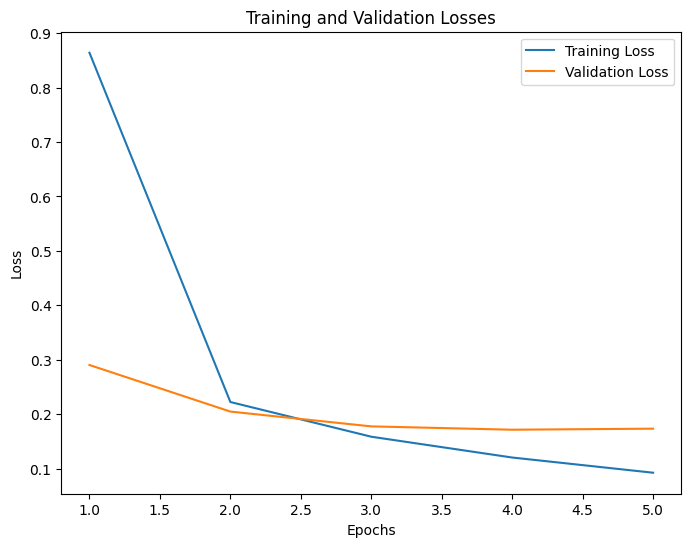

In [16]:
epochs = range(1, 6)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses[:-2], label='Training Loss')
plt.plot(epochs, valid_losses[:-2], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [2]:
from models.resnet34 import resnet34
import torch
import dataset.create_dataset as D
from mapping import grapheme_root_components,vowel_diacritic_components,consonant_diacritic_components

_, test_loader, _ = D.dividing_datasets(128, 224)
device  = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the same model architecture as in the training script
model = resnet34().to(device)

# Load the trained weights
model.load_state_dict(torch.load('char_level_trained_model_128x224_shoroborno_again.pth'))

<All keys matched successfully>

In [3]:
def show_char(grapheme_root,vowel_diacritic,consonant_diacritic):
    correct_char = []
    
    if(vowel_diacritic != 0 and consonant_diacritic != 0):
        if(consonant_diacritic == 2):
            correct_char.append( consonant_diacritic_components[consonant_diacritic] +  grapheme_root_components[grapheme_root] + vowel_diacritic_components[vowel_diacritic] )
        elif(consonant_diacritic == 1):
            correct_char.append(grapheme_root_components[grapheme_root] + vowel_diacritic_components[vowel_diacritic] + consonant_diacritic_components[consonant_diacritic])
        else:
            correct_char.append(grapheme_root_components[grapheme_root] + consonant_diacritic_components[consonant_diacritic] + vowel_diacritic_components[vowel_diacritic])
    
    elif(vowel_diacritic == 0 and consonant_diacritic == 0):
        correct_char.append(grapheme_root_components[grapheme_root])

    else:
        if(vowel_diacritic == 0):
            if(consonant_diacritic == 2):
                correct_char.append( consonant_diacritic_components[consonant_diacritic] +  grapheme_root_components[grapheme_root] )
            else:
                correct_char.append(grapheme_root_components[grapheme_root] + consonant_diacritic_components[consonant_diacritic])
        else:
            correct_char.append(grapheme_root_components[grapheme_root] + vowel_diacritic_components[vowel_diacritic])
            
    return correct_char         

In [5]:
import torch

total = len(test_loader.dataset)

acc1 = 0.0
acc2 = 0.0
acc3 = 0.0
loss = 0.0

for idx in range(total):
    img = test_loader.dataset[idx]["image"]

    grapheme_root = test_loader.dataset[idx]["grapheme_root"]

    vowel_diacritic = test_loader.dataset[idx]["vowel_diacritic"]

    consonant_diacritic = test_loader.dataset[idx]["consonant_diacritic"]


    input_image = img.unsqueeze(0) 

    input_image = input_image.to(device)

    model.eval()

    # Move the model to the GPU (if not already)
    model = model.to(device)

    # Forward pass to get model predictions
    with torch.no_grad():
        outputs = model(input_image)

    # Find the index of the maximum probability for each class
    predicted_grapheme_idx = torch.argmax(outputs[0]).item()
    predicted_vowel_idx = torch.argmax(outputs[1]).item()
    predicted_consonant_idx = torch.argmax(outputs[2]).item()

    predicted_grapheme_root = torch.tensor(predicted_grapheme_idx)
    predicted_vowel_diacritic = torch.tensor(predicted_vowel_idx)
    predicted_consonant_diacritic = torch.tensor(predicted_consonant_idx)

    is_grapheme_root_correct = torch.equal(grapheme_root, predicted_grapheme_root)
    is_vowel_diacritic_correct = torch.equal(vowel_diacritic, predicted_vowel_diacritic)
    is_consonant_diacritic_correct = torch.equal(consonant_diacritic, predicted_consonant_diacritic)

    if is_grapheme_root_correct and is_vowel_diacritic_correct and is_consonant_diacritic_correct:
        acc3 += 1

    elif (is_grapheme_root_correct and is_vowel_diacritic_correct) or (is_vowel_diacritic_correct and is_consonant_diacritic_correct) or (is_grapheme_root_correct and is_consonant_diacritic_correct):
        acc2 += 1

    elif is_grapheme_root_correct or is_vowel_diacritic_correct or is_consonant_diacritic_correct:
        acc1 += 1
    else:
        loss += 1

avg_acc1 = acc1/total
avg_acc2 = acc2/total
avg_acc3 = acc3/total
avg_loss = loss/total

print(f"avg_acc1: {avg_acc1*100}, avg_acc2: {avg_acc2*100}, avg_acc3:{avg_acc3*100}\n loss: {avg_loss*100}")

avg_acc1: 1.7996727867660427, avg_acc2: 10.575349936375204, avg_acc3:87.52499545537175
 loss: 0.09998182148700237


['র্মা'], ['র্মা']


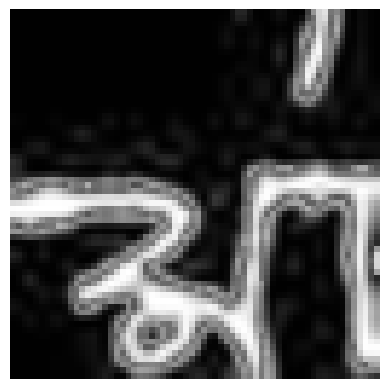

['ষো'], ['ষো']


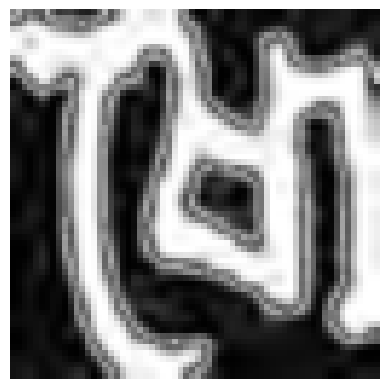

['ন্ত্রা'], ['দ্ভা']


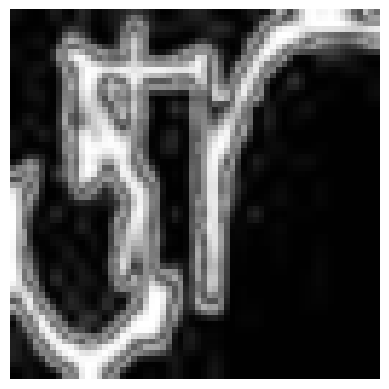

['য্যা'], ['ষ্যা']


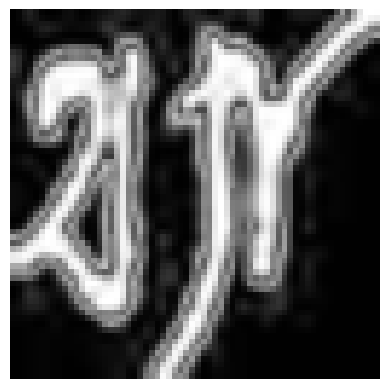

['স্তি'], ['স্তি']


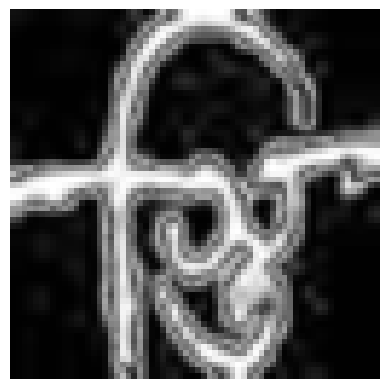

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Randomly select 16 indices from the dataset
random_indices = random.sample(range(len(test_loader.dataset)), 5)

saved_indices = random_indices
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL Image
    transforms.Resize((64, 64)),  # Resize the PIL Image
    transforms.ToTensor()  # Convert PIL Image back to tensor
])

# Loop through the randomly selected indices
for i, idx in enumerate(random_indices):
    # Access the dataset associated with the DataLoader
    img = test_loader.dataset[idx]["image"]

    grapheme_root = test_loader.dataset[idx]["grapheme_root"].item()

    vowel_diacritic = test_loader.dataset[idx]["vowel_diacritic"].item()

    consonant_diacritic = test_loader.dataset[idx]["consonant_diacritic"].item()


    input_image = img.unsqueeze(0) 

    input_image = input_image.to(device)


    # Ensure the model is in evaluation mode
    model.eval()

    # Move the model to the GPU (if not already)
    model = model.to(device)

    # Forward pass to get model predictions
    with torch.no_grad():
        outputs = model(input_image)

    # Find the index of the maximum probability for each class
    predicted_grapheme_idx = torch.argmax(outputs[0]).item()
    predicted_vowel_idx = torch.argmax(outputs[1]).item()
    predicted_consonant_idx = torch.argmax(outputs[2]).item()


    correct_char = show_char(grapheme_root,vowel_diacritic,consonant_diacritic)

    #predicted characters:

    pred_char = show_char(predicted_grapheme_idx,predicted_vowel_idx,predicted_consonant_idx)
            
    resized_image = transform(img)        
    img_np = np.transpose(resized_image.numpy(),(1,2,0))
    print(f"{correct_char}, {pred_char}")
    plt.imshow(img_np,cmap='gray')
    plt.axis('off')
    plt.show()
      


(212, 452)
(224, 128)


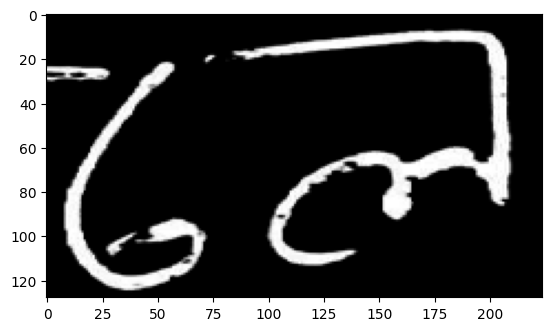

['ল']


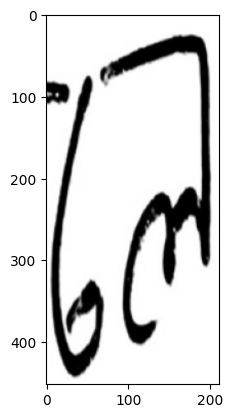

In [12]:
from PIL import Image,ImageOps,ImageEnhance
import matplotlib.pyplot as plt
from torchvision import transforms

image_path = 'data/BanglaGrapheme/লে_2.jpg'
img = Image.open(image_path).convert('RGB')
print(img.size)
enhancer = ImageEnhance.Brightness(img)
factor = 10
img_en = enhancer.enhance(factor)
img_inv = ImageOps.invert(img_en)
img_resize = img_inv.resize((224,128))
print(img_resize.size)
plt.imshow(img_resize,cmap='gray')
plt.show() 
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)) 
        ])

img_ten = transform(img_resize)

input_image = img_ten.unsqueeze(0) 

input_image = input_image.to(device)

model.eval()

# Move the model to the GPU (if not already)
model = model.to(device)

# Forward pass to get model predictions
with torch.no_grad():
    outputs = model(input_image)

# Find the index of the maximum probability for each class
predicted_grapheme_idx = torch.argmax(outputs[0]).item()
predicted_vowel_idx = torch.argmax(outputs[1]).item()
predicted_consonant_idx = torch.argmax(outputs[2]).item()

predicted_grapheme_root = torch.tensor(predicted_grapheme_idx)
predicted_vowel_diacritic = torch.tensor(predicted_vowel_idx)
predicted_consonant_diacritic = torch.tensor(predicted_consonant_idx)

pred_char = []

if(predicted_vowel_idx != 0 and predicted_consonant_idx != 0):
        if(predicted_consonant_idx == 2):
            pred_char.append( consonant_diacritic_components[predicted_consonant_idx] +  grapheme_root_components[predicted_grapheme_idx] + vowel_diacritic_components[predicted_vowel_idx] )
        elif(predicted_consonant_idx == 1):
            pred_char.append(grapheme_root_components[predicted_grapheme_idx] + vowel_diacritic_components[predicted_vowel_idx] + consonant_diacritic_components[predicted_consonant_idx])
        else:
            pred_char.append(grapheme_root_components[predicted_grapheme_idx] + consonant_diacritic_components[predicted_consonant_idx] + vowel_diacritic_components[predicted_vowel_idx])
   
elif(predicted_vowel_idx == 0 and predicted_consonant_idx == 0):
    pred_char.append(grapheme_root_components[predicted_grapheme_idx])

else:
    if(predicted_vowel_idx == 0):
        if(predicted_consonant_idx == 2):
            pred_char.append( consonant_diacritic_components[predicted_consonant_idx] +  grapheme_root_components[predicted_grapheme_idx] )
        else:
            pred_char.append(grapheme_root_components[predicted_grapheme_idx] + consonant_diacritic_components[predicted_consonant_idx])
    else:
        pred_char.append(grapheme_root_components[predicted_grapheme_idx] + vowel_diacritic_components[predicted_vowel_idx])
        
print(pred_char)  

plt.imshow(img,cmap='gray')
plt.show()        
